<a href="https://colab.research.google.com/github/assafkeller/RNN/blob/main/RNN_EQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from google.colab import files
uploaded = files.upload()

Saving Cond. Carmel.csv to Cond. Carmel.csv


In [57]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Cond. Carmel.csv']),usecols=['date', 'Cond. Carmel'])

In [58]:
df.head()

,date,Cond. Carmel
0,25/06/2015 00:00,4642
1,25/06/2015 00:01,4639
2,25/06/2015 00:02,4576
3,25/06/2015 00:03,4615
4,25/06/2015 00:04,4611


In [59]:
def to_international_date(d):

 tmp = d.split(' ')
 date1 = tmp[0]
 hour = tmp[1]
 
 date = date1.split('/')
 day   = date[0]
 month = date[1]
 year  = date[2]
 return '%s-%s-%s %s' % (year, month, day,hour)

In [60]:
# Convert to the date format
df['date'] = df['date'].apply(to_international_date)

# Convert date and time to datetime
df['datetime'] = pd.to_datetime(df['date'])

# Drop columns
df = df.drop(['date'], axis=1)

# Clean the data
df = df[df['Cond. Carmel'] != '-']
# Set the type of temp to float
df['Cond. Carmel'] = df['Cond. Carmel'].astype(float)



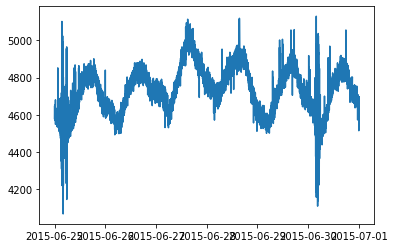

In [61]:
# Plot and describe the data
plt.plot(df['datetime'], df['Cond. Carmel'])

In [62]:
# Set the index
df = df.set_index('datetime')

In [63]:
# Describe
df.describe()

,Cond. Carmel
count,8637.000000
mean,4749.809656
std,125.899776
min,4066.000000
25%,4663.000000
50%,4755.000000
75%,4838.000000
max,5130.000000


In [64]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8637 entries, 2015-06-25 00:00:00 to 2015-06-30 23:59:00
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cond. Carmel  8637 non-null   float64
dtypes: float64(1)
memory usage: 135.0 KB


(8637, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


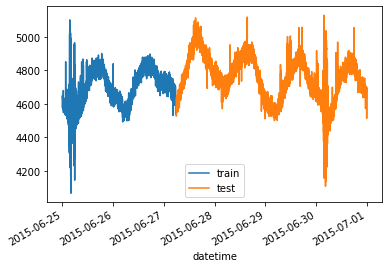

In [70]:
## Separate between the train and test datasets
split_date = pd.datetime(2015, 6, 27, 5, 53)

dataset_train = df[:split_date]
dataset_test  = df[split_date:]

# Plot the datasets
ax = dataset_train.plot()
dataset_test.plot(ax=ax)
plt.legend(['train','test'])

In [71]:
# Scale the datasets
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_test_scaled  = scaler.transform(dataset_test)

print(dataset_train_scaled[:5]) # The first 5 data points
print(dataset_test_scaled[-5:]) # The last 5 data points

[[0.55598456]
 [0.5530888 ]
 [0.49227799]
 [0.52992278]
 [0.52606178]]
[[0.60521236]
 [0.43243243]
 [0.57722008]
 [0.5984556 ]
 [0.59942085]]


In [72]:
# Takes a series of 30 time points as feature and the next point as label
def create_dataset(df):
  x = [] # features from the previous 50 time points
  y = [] # labels from the current time points
  
  for i in range(30, df.shape[0]):
    x.append(df[i-30:i,0])
    y.append(df[i,0])
    
  x = np.array(x)
  y = np.array(y)
  
  return x,y

In [73]:
x_train, y_train = create_dataset(dataset_train_scaled)

In [74]:
x_test, y_test = create_dataset(dataset_test_scaled)

In [75]:
print(x_train.shape)
print(x_test.shape)

(3202, 30)
(5376, 30)


In [76]:
# Reshape data for LSTM layer
# Make a 2 dimensional tuple into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test  = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print(x_test.shape)

(3202, 30, 1)
(5376, 30, 1)


In [77]:
model = Sequential()

model.add(LSTM(units=48, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=48, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=48))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 48)            9600      
                                                                 
 dropout (Dropout)           (None, 30, 48)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 48)            18624     
                                                                 
 dropout_1 (Dropout)         (None, 30, 48)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_2 (Dropout)         (None, 48)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [79]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=2,
                   mode='auto')

In [81]:
model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test,y_test), callbacks=[es])

Epoch 1/200
101/101 [==============================] - 14s 77ms/step - loss: 0.0224 - val_loss: 0.0050
Epoch 2/200
101/101 [==============================] - 6s 63ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 3/200
101/101 [==============================] - 10s 102ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 4/200
101/101 [==============================] - 6s 64ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 4: early stopping


Text(0.5, 1.0, 'Actual vs predicted in the train dataset')

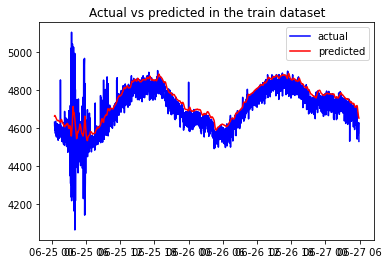

In [82]:
# First, predict from the train dataset
predicted_train = model.predict(x_train)

# Convert the scaled data back to the original values
predicted_train_rescaled = scaler.inverse_transform(predicted_train)

# Plot
# Pop the first 30 values from the timeseries
x_axis = dataset_train.index[30:]

# Visualize the predicted values against the actual data
#  but first we need to convert back to the actual data
actual_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

plt.plot(x_axis, actual_train_rescaled, 'b')
plt.plot(x_axis, predicted_train_rescaled, 'r')
plt.legend(['actual','predicted'])
plt.title("Actual vs predicted in the train dataset")

In [83]:
import math
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(actual_train_rescaled, predicted_train_rescaled))
print('Train Score: %.2f RMSE' % (train_score))

Train Score: 68.37 RMSE


Text(0.5, 1.0, 'Actual vs predicted in the test dataset')

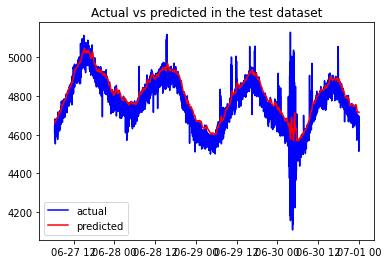

In [84]:
# Predict on the test dataset
predictions = model.predict(x_test)

# Convert back to the original values
predictions = scaler.inverse_transform(predictions)

# Plot
# Pop the first 30 values from the timeseries that
x_axis = dataset_test.index[30:]

# Visualize the predicted values against the actual data
#  but first we need to convert back the actual data
actual_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize the predicted values against the actual data
plt.plot(x_axis, actual_test_rescaled, 'b')
plt.plot(x_axis, predictions, 'r')
plt.legend(['actual','predicted'])
plt.title("Actual vs predicted in the test dataset")

In [85]:
test_score = math.sqrt(mean_squared_error(actual_test_rescaled, predictions))
print('Test Score: %.2f RMSE' % (test_score))

Test Score: 58.73 RMSE
